In [1]:
%cd /data/nijhawanlab/amplicons/VK008/
R1_file = "VK008_R1_001.fastq.gz"
R2_file = "VK008_R2_001.fastq.gz"
primer_file = "primers.txt"
samples_file = "VK008_samples.tsv"
experiment = "VK008"
minimum_read_quality = 20
minimum_barcode_length = 14
maximum_barcode_length = 30

/data/nijhawanlab/amplicons/VK008


In [2]:
! md5sum --check md5sum_list.txt

./VK008_R2_001.fastq.gz: OK
./VK008_R1_001.fastq.gz: OK


In [3]:
seqkit_output = ! seqkit stats *.fastq.gz

In [4]:
from Bio import Seq, SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import csv
import itertools
import re
# import xlwt, openpyxl
from colored import fg, bg, attr
from itertools import cycle
from tqdm import tqdm
from io import StringIO
import locale

from IPython.core.display import display, HTML


In [5]:
files_table = pd.read_fwf(
    StringIO('\n'.join(seqkit_output)), 
    header = 0,
    thousands = ','
)
files_table

,file,format,type,num_seqs,sum_len,min_len,avg_len,max_len
0,VK008_R1_001.fastq.gz,FASTQ,DNA,446056,82511046,35,185.0,250
1,VK008_R2_001.fastq.gz,FASTQ,DNA,446056,82776533,35,185.6,250


In [6]:
num_seqs = files_table['num_seqs'].max()
num_seqs

446056

In [7]:
reference_sequence_pre = 'TTCTTGACGAGTTCTTCTGA' # TTCTTGACGAGTTCTTCTGA
reference_sequence_post = 'ACGCGTCTGGAACAATCAAC' # ACGCGTCTGGAACAATCAAC
reference_barcode = 'SWSWSWSWSWSWSWSWSWSW'

In [8]:
# This works to make output cell wide, with a horiztonal scroll bar.
# https://stackoverflow.com/questions/48357459/make-cell-output-in-jupyter-notebook-scroll-horizontally
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [9]:
# change the cell width
# This doesn't scroll, just makes the cells wide.
display(HTML("<style>.container { width:100% !important; }</style>"))

In [10]:
pd.__version__

'1.0.3'

In [11]:
def export_figure(fig, title, metadata={}):
    fig_metadata = {
        "Comment" : "experiment:" + experiment
    }
    fig_metadata.update(metadata)
    filename = experiment + "_" + title + ".png"
    fig.savefig(filename, metadata = fig_metadata)

In [12]:
def colorIntervals(seq, intervals, 
                   default_color = bg('black')+fg('white'), 
                   color_list = [
                       bg('grey_50')+fg('black'), bg('grey_85')+fg('white'), 
                       bg('grey_50')+fg('black'), bg('orange_red_1'), bg('dark_blue')], 
                   offset=0):
    color = cycle(color_list)
    intervals.sort()
    if any(intervals[i+1][0]-intervals[i][1] <=0 for i in range(len(intervals)-1)):
        print("ColorSeq: Intervals cannot overlap.")
        return seq
    colored_string = default_color + offset*' ' # seq[:intervals[0][0]]
    last_index = 0 # intervals[0][1]
    for interval in intervals:
        colored_string += seq[last_index:interval[0]]
        c = next(color)
        colored_string += c + seq[interval[0]:interval[1]] + default_color
        last_index = interval[1]
    colored_string += seq[last_index:] + bg(0) + fg(0) + attr('reset')
    return colored_string

## Read Input Files

### Read in primers.txt and store primers in various useful forms

In [13]:
primers = []
with open(primer_file, newline='') as primers_IO:
    primer_reader = csv.DictReader(
        primers_IO, 
        delimiter='\t', 
        fieldnames=['OriginalSeq','sequence','barcode','direction'])
    for primer in primer_reader:
        primers.append(dict(primer))

primers

[{'OriginalSeq': 'oVK025',
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCTTG ',
  'direction': 'F'},
 {'OriginalSeq': 'oVK031',
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'barcode': 'GCCGAA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK032',
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'barcode': 'TACTGC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK033',
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'barcode': 'GAACGT',
  'direction': 'F'},
 {'OriginalSeq': 'oVK034',
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'barcode': 'TATCCA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK035',
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'barcode': 'CTCCGG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK036',
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCACC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK037',
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCGAG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK026',
  'sequence': 'TTTTGTCACCCAGAGGTTGAT

In [14]:
forward_primers = [p['OriginalSeq'] for p in primers if p['direction']=='F']
reverse_primers = [p['OriginalSeq'] for p in primers if p['direction']=='R']

[forward_primers, reverse_primers]

[['oVK025',
  'oVK031',
  'oVK032',
  'oVK033',
  'oVK034',
  'oVK035',
  'oVK036',
  'oVK037'],
 ['oVK026',
  'oVK038',
  'oVK039',
  'oVK040',
  'oVK041',
  'oVK042',
  'oVK043',
  'oVK044',
  'oVK045',
  'oVK046',
  'oVK047',
  'oVK048']]

In [15]:
primer_lookup = {p['OriginalSeq']: 
                 {'len':len(p['sequence']), 
                  'sequence':p['sequence'],
                  'direction':p['direction']
                 } for p in primers}

In [16]:
primer_lookup

{'oVK025': {'len': 28,
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK031': {'len': 28,
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK032': {'len': 28,
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK033': {'len': 28,
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK034': {'len': 28,
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK035': {'len': 28,
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK036': {'len': 28,
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK037': {'len': 28,
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK026': {'len': 30,
  'sequence': 'TTTTGTCACCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK038': {'len': 30,
  'sequence': 'TTTGTTAATCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK039': {'len': 30,
  'sequence': 'TTTTATGGTCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oV

### Load paired reads from FASTQ files

In [17]:
basePair = {'A':'T','T':'A','G':'C','C':'G'}
basePairTrans = str.maketrans(basePair)
def rcDNA(seq):
    return seq.translate(basePairTrans) [::-1]
def cDNA(seq):
    return seq.translate(basePairTrans)

In [18]:
def IdPrimers(seq):
    found_primers = {
        'fwd_primer':None,
        'fwd_primer_loc':None, 
        'rc_primer':None, 
        'rc_primer_loc':None, 
        'fwd_direction':None,
        'rc_direction':None
    }
    for p in primers:
        p1 = seq.find(p['sequence'])
        if p1 != -1:
            found_primers['fwd_primer'] = p['OriginalSeq']
            found_primers['fwd_primer_loc'] = p1
            found_primers['fwd_direction'] = p['direction']
        p2 = seq.rfind( rcDNA( p['sequence'] ))
        if p2 != -1:
            found_primers['rc_primer'] = p['OriginalSeq']
            found_primers['rc_primer_loc'] = p2
            found_primers['rc_direction'] = p['direction']
    return found_primers

In [19]:
def sanity_id_match(full_read):
    return full_read['F_id'] == full_read['R_id']

def sanity_primer_match(full_read):
    return (
        (full_read['F_forward_primer'] == full_read['R_rc_primer']) &
        (full_read['F_rc_primer'] == full_read['R_forward_primer'])
    )

def sanity_all_primers_found(full_read):
    return (
        (full_read['F_forward_primer'] != None) & 
        (full_read['F_rc_primer'] != None) &
        (full_read['R_forward_primer'] != None) & 
        (full_read['R_rc_primer'] != None)
    )

def sanity_barcodes_match(full_read):
    # print(full_read['F_barcode']) 
    # print(full_read['R_barcode'])
    return (full_read['F_barcode'] == full_read['R_barcode'])

def sanity_barcodes_length(full_read):
    lF = len(full_read['F_barcode'])
    lR = len(full_read['R_barcode'])
    return (
        (lF <= maximum_barcode_length) &
        (lF >= minimum_barcode_length) &
        (lR <= maximum_barcode_length) &
        (lR >= minimum_barcode_length)
    )

sanity_barcode_regex = re.compile('([GC][AT])+[GC]?')
def sanity_barcode_pattern(full_read):
    if sanity_barcode_regex.fullmatch(full_read['R_barcode']):
        return True
    else:
        return False
    
def sanity_barcodes_quality(full_read):
    return (
        (min(full_read['F_quality']) >= minimum_read_quality) &
        (min(full_read['R_quality']) >= minimum_read_quality)
    )

sanity_checks = [
    {
        'id':'any',
        'label':'Any Check',
        'description':'Read pairs failing any sanity check.',
        'function':(lambda _: True)
    },
    {
        'id':'id_match',
        'label':'IDs Match',
        'description':'R1 & R2 read IDs match.',
        'function':sanity_id_match},
    {
        'id':'primer_match',
        'label':'Primers Match',
        'description':'Forward & reverse primers for R1 & R2 match.',
        'function':sanity_primer_match
    },
    {
        'id':'primers_found',
        'label':'Primers Found',
        'description':'Forward & reverse primers identified in both reads.',
        'function':sanity_all_primers_found
    },
    {
        'id':'barcodes_match',
        'label':'Barcodes Match',
        'description':'Barcodes from R1 & R2 reads match exactly.',
        'function':sanity_barcodes_match
    },
    {
        'id':'barcode_length',
        'label':'Barcode Length',
        'description':'Barcode lengths are within the required range.',
        'function':sanity_barcodes_length
    },
    {
        'id':'barcode_pattern',
        'label':'Barcode Pattern',
        'description':'The R1 barcode matches the specified pattern (SWSW...).',
        'function':sanity_barcode_pattern
    },
    {
        'id':'barcodes_quality',
        'label':'Barcode Read Quality',
        'description':'The minimum read quality (PHRED score) for both barcodes is at least the minumum specified.',
        'function':sanity_barcodes_quality
    }
]

In [20]:
def analyzeReads(F_read, R_read, F_primers, R_primers):
    r = {}
    r['F_id'] = F_read.id
    r['R_id'] = R_read.id
    r['F_forward_primer'] = F_primers['fwd_primer']
    r['F_rc_primer'] = F_primers['rc_primer']
    r['R_forward_primer'] = R_primers['fwd_primer']
    r['R_rc_primer'] = R_primers['rc_primer']

    r['F_pre_loc'] = F_read.seq.find(reference_sequence_pre)
    r['F_post_loc'] = F_read.seq.find(reference_sequence_post)
    r['R_pre_loc'] = R_read.seq.find( rcDNA(reference_sequence_pre) ) 
    r['R_post_loc'] = R_read.seq.find( rcDNA(reference_sequence_post) ) 
    r['F_barcode_loc'] = [r['F_pre_loc']+len(reference_sequence_pre), r['F_post_loc']]
    r['R_barcode_loc'] = [r['R_post_loc']+len(reference_sequence_post), r['R_pre_loc']]
    r['F_barcode'] = str(F_read.seq)[ r['F_barcode_loc'][0] : r['F_barcode_loc'][1]]
    r['R_barcode'] = rcDNA( str(R_read.seq)[ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ] )
    
    r['F_quality'] = F_read.letter_annotations["phred_quality"][ r['F_barcode_loc'][0] : r['F_barcode_loc'][1] ]
    r['R_quality'] = R_read.letter_annotations["phred_quality"][ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ]
    
    return r

In [21]:
def pad_list(l, length, element):
    if len(l) < length:
        l.extend( [element for _ in range(length - len(l))] )
        return l
    else:
        return l

# It is necessary to create lists of dictionaries differently from lists of integers,
# because if you use the strategy above you get a list where every element is the same dict.
def pad_dict_list(l, length):
    if len(l) < length:
        l.extend( [dict() for _ in range(length - len(l))] )
        return l
    else:
        return l    

In [22]:
with gzip.open(R1_file, "rt") as R1:
    with gzip.open(R2_file, "rt") as R2:
        reads1 = SeqIO.parse(R1, "fastq")
        reads2 = SeqIO.parse(R2, "fastq")
        maxReads = num_seqs
        readNumber = 1
        reads_list = []
        quality_statistics = {
            "R1": {
                "read_counts":[], 
                "N_counts":[],
                "phred_scores":[],
                "read_lengths":[]
            }, 
            "R2": {
                "read_counts":[], 
                "N_counts":[],
                "phred_scores":[],
                "read_lengths":[]
            }
        }
        sanity_failures = {i['id']:0 for i in sanity_checks}
        
        progress_bar = tqdm(total=maxReads)
        for (read1, read2) in zip(reads1, reads2):
            R1_sequence = str(read1.seq)
            R2_sequence = str(read2.seq)
            R1_quality = read1.letter_annotations["phred_quality"]
            R2_quality = read2.letter_annotations["phred_quality"]
            R1_primers = IdPrimers(R1_sequence)
            R2_primers = IdPrimers(R2_sequence)
    
            R1_length = len(R1_sequence)
            R2_length = len(R2_sequence)
            quality_statistics["R1"]["read_counts"] = pad_list(quality_statistics["R1"]["read_counts"], R1_length, 0)
            quality_statistics["R2"]["read_counts"] = pad_list(quality_statistics["R2"]["read_counts"], R2_length, 0)
            quality_statistics["R1"]["N_counts"] = pad_list(quality_statistics["R1"]["N_counts"], R1_length, 0)
            quality_statistics["R2"]["N_counts"] = pad_list(quality_statistics["R2"]["N_counts"], R2_length, 0)
            quality_statistics["R1"]["phred_scores"] = pad_dict_list(quality_statistics["R1"]["phred_scores"], R1_length)
            quality_statistics["R2"]["phred_scores"] = pad_dict_list(quality_statistics["R2"]["phred_scores"], R2_length)
            
            quality_statistics["R1"]["read_lengths"].append(R1_length)
            quality_statistics["R2"]["read_lengths"].append(R2_length)
            for i in range(R1_length):
                quality_statistics["R1"]["read_counts"][i] += 1
                if R1_sequence[i] == 'N':
                    quality_statistics["R1"]["N_counts"][i] += 1
                q = R1_quality[i]
                if q in quality_statistics["R1"]["phred_scores"][i]:
                    quality_statistics["R1"]["phred_scores"][i][ q ] += 1
                else:
                    quality_statistics["R1"]["phred_scores"][i][ q ] = 1
                        
            for i in range(R2_length):
                quality_statistics["R2"]["read_counts"][i] += 1
                if R2_sequence[i] == 'N':
                    quality_statistics["R2"]["N_counts"][i] += 1
                q = R2_quality[i]
                if q in quality_statistics["R2"]["phred_scores"][i]:
                    quality_statistics["R2"]["phred_scores"][i][ q ] += 1
                else:
                    quality_statistics["R2"]["phred_scores"][i][ q ] = 1

            if R1_primers['fwd_direction'] == 'F':
                full_read = analyzeReads(read1, read2, R1_primers, R2_primers)
            else:
                full_read = analyzeReads(read2, read1, R2_primers, R1_primers)
                                
            any_failure = False
            for check in sanity_checks:
                try:
                    test_passes = check['function'](full_read)
                except ValueError:
                    test_passes = False
                if not test_passes:
                    sanity_failures[check['id']] += 1
                    any_failure = True
            if any_failure:
                sanity_failures['any'] += 1
            else:
                reads_list.append(
                    {'barcode':full_read['F_barcode'],
                     'forward_primer':full_read['F_forward_primer'],
                     'reverse_primer':full_read['F_rc_primer']
                    }
                )
            progress_bar.update(1)
            if readNumber == maxReads:
                break
            readNumber += 1

        progress_bar.close()

#for i in sanity_failures:
#    sanity_failures[i['id']]['label'] = sanity_checks[i['id']]
            
print("maxReads: {}\nTotal reads: {}".format(maxReads,readNumber))
# reads_table = pd.DataFrame(reads_list)

100%|██████████| 446056/446056 [02:37<00:00, 2839.34it/s]

maxReads: 446056
Total reads: 446056


In [23]:
sanity_failures

{'any': 262185,
 'id_match': 0,
 'primer_match': 25824,
 'primers_found': 203420,
 'barcodes_match': 82467,
 'barcode_length': 70999,
 'barcode_pattern': 78667,
 'barcodes_quality': 132857}

In [24]:
sanity_checks_lookup = {i["id"]:i["label"] for i in sanity_checks} 
[[i, sanity_failures[i], sanity_checks_lookup[i]] for i in sanity_failures]

[['any', 262185, 'Any Check'],
 ['id_match', 0, 'IDs Match'],
 ['primer_match', 25824, 'Primers Match'],
 ['primers_found', 203420, 'Primers Found'],
 ['barcodes_match', 82467, 'Barcodes Match'],
 ['barcode_length', 70999, 'Barcode Length'],
 ['barcode_pattern', 78667, 'Barcode Pattern'],
 ['barcodes_quality', 132857, 'Barcode Read Quality']]

In [25]:
checks_data_frame = pd.DataFrame(
    [[i, sanity_failures[i], sanity_checks_lookup[i]] for i in sanity_failures],
    columns = ['id', 'count', 'label']
).sort_values('count', ascending=False)

In [26]:
checks_data_frame

,id,count,label
0,any,262185,Any Check
3,primers_found,203420,Primers Found
7,barcodes_quality,132857,Barcode Read Quality
4,barcodes_match,82467,Barcodes Match
6,barcode_pattern,78667,Barcode Pattern
5,barcode_length,70999,Barcode Length
2,primer_match,25824,Primers Match
1,id_match,0,IDs Match


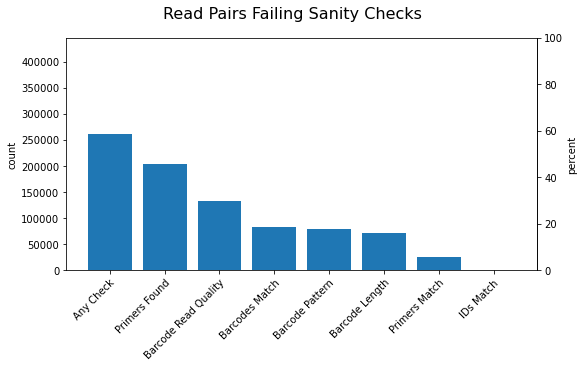

In [27]:
fig_sanity, ax_sanity = plt.subplots(constrained_layout=True, figsize=(8,5))
fig_sanity.suptitle('Read Pairs Failing Sanity Checks', fontsize=16)

ax_sanity.bar(data=checks_data_frame, height='count', x='label')

def n_to_percent(n):
    return 100*n/readNumber

def percent_to_n(p):
    return p*readNumber/100

secax = ax_sanity.secondary_yaxis('right', functions=(n_to_percent, percent_to_n))
secax.set_ylabel('percent')
ax_sanity.set_ylabel('count')
ax_sanity.set_ylim([0, readNumber])
plt.setp(ax_sanity.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [28]:
export_figure(fig_sanity, "sanity_checks")

In [29]:
def SeqDiagnosticPlot(quality_statistics, maintitle="Read Quality"):

    def mean_from_dictionary_of_counts(d):
        M = 0
        T = 0
        for k in d:
            M += k*d[k]
            T += d[k]
        return M/T
    
    max_length = len(quality_statistics["read_counts"])
    positions = range(1, max_length + 1)
    max_qual_by_position = [max( [k for k in d] ) for d in quality_statistics["phred_scores"]]
    min_qual_by_position = [min( [k for k in d] ) for d in quality_statistics["phred_scores"]]
    mean_qual_by_position = [mean_from_dictionary_of_counts(d) for d in quality_statistics["phred_scores"]]
    max_N_count = max([10, max( quality_statistics["N_counts"] )])
    
    fig, (axis_quality, axis_N, axis_read_count) = plt.subplots(
        3,1,
        sharex='all',
        figsize=(15,7)
    )
    fig.suptitle(maintitle, fontsize=16)
    
    min_max_handle = axis_quality.fill_between(
        x=positions, 
        y1=min_qual_by_position, 
        y2=max_qual_by_position, 
        color="lightgrey", 
        label='range')
    mean_handle, = axis_quality.step(
        x=positions,
        y=mean_qual_by_position, 
        label='mean')
    axis_quality.legend(loc='lower center')
    axis_quality.set_xlabel('position')
    axis_quality.set_ylabel('quality')
    axis_quality.yaxis.grid(True)
    axis_quality.spines["bottom"].set_visible(True)
    axis_quality.spines["top"].set_visible(False)
    axis_quality.spines["left"].set_visible(True)
    axis_quality.spines["right"].set_visible(False)
    
    axis_read_count.set_yscale('log')
    axis_read_count.plot(quality_statistics["read_counts"], color='grey')
    axis_read_count.hist(quality_statistics["read_lengths"], range=(0,max_length), bins=25, color='lightblue')
    axis_read_count.set_ylabel('read count')
    axis_read_count.spines["bottom"].set_visible(True)
    axis_read_count.spines["top"].set_visible(False)
    axis_read_count.spines["left"].set_visible(True)
    axis_read_count.spines["right"].set_visible(False)
    
    axis_N.spines["bottom"].set_visible(True)
    axis_N.spines["top"].set_visible(False)
    axis_N.spines["left"].set_visible(True)
    axis_N.spines["right"].set_visible(False)
    axis_N.set_ylim([0, max_N_count])
    axis_N.step(x=positions, y=quality_statistics["N_counts"])
    axis_N.set_ylabel('N content')

    return fig

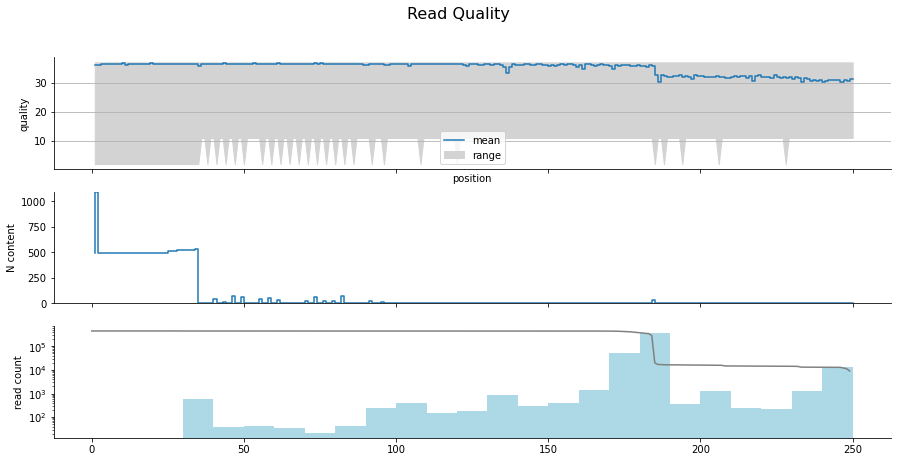

In [30]:
fig_R1 = SeqDiagnosticPlot(quality_statistics["R1"])

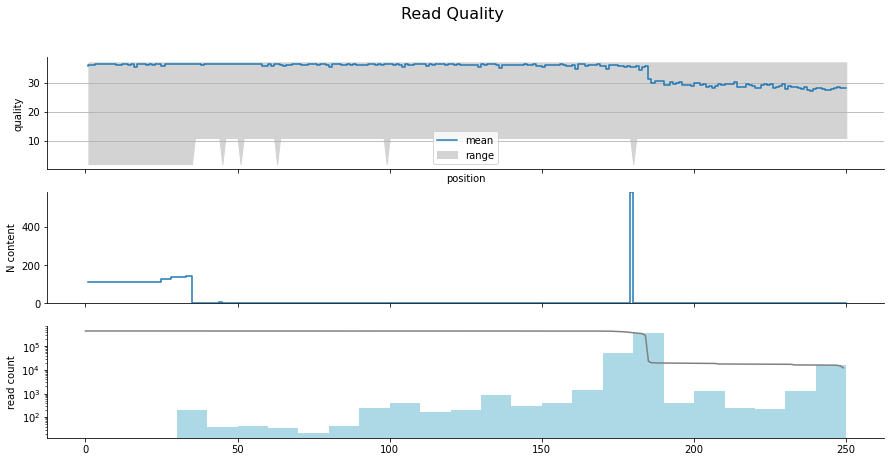

In [31]:
fig_R2 = SeqDiagnosticPlot(quality_statistics["R2"])

In [32]:
export_figure(fig_R1, "R1_quality")
export_figure(fig_R2, "R2_quality")

In [33]:
reads_list[0:5]

[{'barcode': 'GTGTGTGTCACTGTCTCTGACAGA',
  'forward_primer': 'oVK037',
  'reverse_primer': 'oVK048'},
 {'barcode': 'GTGTCTCTGTCTCAGTGAGACACT',
  'forward_primer': 'oVK025',
  'reverse_primer': 'oVK026'},
 {'barcode': 'GACTGTGTCAGTGAGAGTGACTCT',
  'forward_primer': 'oVK033',
  'reverse_primer': 'oVK043'},
 {'barcode': 'GTCAGTGAGACTCTCTCAGAGTGT',
  'forward_primer': 'oVK033',
  'reverse_primer': 'oVK048'},
 {'barcode': 'GTCACTGTGTGTCTGACTCTGAGT',
  'forward_primer': 'oVK031',
  'reverse_primer': 'oVK040'}]

In [34]:
with open(samples_file, 'r') as f:
    samples_table = f.read()
    print(samples_table)

FileNotFoundError: [Errno 2] No such file or directory: 'VK008_samples.tsv'

In [36]:
primer_name_regex = re.compile(r"(oVK)(\d{1,3})")

def pad_primer(s):
    m = primer_name_regex.match(s)
    return m.group(1) + m.group(2).rjust(3, '0')

with open(samples_file, "r") as f:
    csvraw = list(csv.reader(f, delimiter='\t'))
col_headers = [pad_primer(h) for h in csvraw[0][1:] ]
row_headers = [ pad_primer(row[0]) for row in csvraw[1:] ]
data = [row[1:] for row in csvraw[1:]]
sample_list = [s for sublist in data for s in sublist if s != '']
sample_dict = {row_headers[r]:{col_headers[c]:data[r][c] for c in range(len(col_headers))} for r in range(0, len(row_headers))}

In [37]:
sample_dict

{'oVK025': {'oVK026': '1514',
  'oVK038': '1515',
  'oVK039': '1516',
  'oVK040': '1517',
  'oVK041': '1518',
  'oVK042': '1519',
  'oVK043': '1520',
  'oVK044': '1521',
  'oVK045': '1522',
  'oVK046': '1523',
  'oVK047': '1524',
  'oVK048': '1525'},
 'oVK031': {'oVK026': '1526',
  'oVK038': '1527',
  'oVK039': '1528',
  'oVK040': '1529',
  'oVK041': '1530',
  'oVK042': '1531',
  'oVK043': '1532',
  'oVK044': '1533',
  'oVK045': '1534',
  'oVK046': '1535',
  'oVK047': '1540',
  'oVK048': '1541'},
 'oVK032': {'oVK026': '1542',
  'oVK038': '1543',
  'oVK039': '1544',
  'oVK040': '1545',
  'oVK041': '1546',
  'oVK042': '1547',
  'oVK043': '1548',
  'oVK044': '1549',
  'oVK045': '1550',
  'oVK046': '1617',
  'oVK047': '1578',
  'oVK048': '1579'},
 'oVK033': {'oVK026': '1580',
  'oVK038': '1581',
  'oVK039': '1582',
  'oVK040': '1583',
  'oVK041': '1584',
  'oVK042': '1585',
  'oVK043': '1586',
  'oVK044': '1587',
  'oVK045': '1588',
  'oVK046': '1618',
  'oVK047': '1619',
  'oVK048': '1634

In [38]:
pd.DataFrame( 
    data = [ [p1, p2, sample_dict[p1][p2]] for p1 in sample_dict for p2 in sample_dict[p1] ],
    columns = ["forward_primer", "reverse_primer", "sample"]
)

,forward_primer,reverse_primer,sample
0,oVK025,oVK026,1514
1,oVK025,oVK038,1515
2,oVK025,oVK039,1516
3,oVK025,oVK040,1517
4,oVK025,oVK041,1518
...,...,...,...
91,oVK037,oVK044,289
92,oVK037,oVK045,431
93,oVK037,oVK046,water
94,oVK037,oVK047,


In [39]:
barcodes = pd.DataFrame(
    reads_list
)

In [40]:
barcodes

,barcode,forward_primer,reverse_primer
0,GTGTGTGTCACTGTCTCTGACAGA,oVK037,oVK048
1,GTGTCTCTGTCTCAGTGAGACACT,oVK025,oVK026
2,GACTGTGTCAGTGAGAGTGACTCT,oVK033,oVK043
3,GTCAGTGAGACTCTCTCAGAGTGT,oVK033,oVK048
4,GTCACTGTGTGTCTGACTCTGAGT,oVK031,oVK040
...,...,...,...
183866,GAGTGAGACAGAGAGACAGTGACA,oVK035,oVK026
183867,CTGAGTGTCAGTCACTCT,oVK025,oVK043
183868,GTGTGTGAGTGACAGTGTGTCTGT,oVK031,oVK039
183869,GAGTCTCTGTCAGAGTCAGTGTCT,oVK036,oVK044


In [41]:
barcodes['sample'] = barcodes.apply(
    lambda row: sample_dict[ row['forward_primer'] ][ row['reverse_primer'] ],
    axis=1
)

In [42]:
barcodes

,barcode,forward_primer,reverse_primer,sample
0,GTGTGTGTCACTGTCTCTGACAGA,oVK037,oVK048,
1,GTGTCTCTGTCTCAGTGAGACACT,oVK025,oVK026,1514
2,GACTGTGTCAGTGAGAGTGACTCT,oVK033,oVK043,1586
3,GTCAGTGAGACTCTCTCAGAGTGT,oVK033,oVK048,1634
4,GTCACTGTGTGTCTGACTCTGAGT,oVK031,oVK040,1529
...,...,...,...,...
183866,GAGTGAGACAGAGAGACAGTGACA,oVK035,oVK026,1600
183867,CTGAGTGTCAGTCACTCT,oVK025,oVK043,1520
183868,GTGTGTGAGTGACAGTGTGTCTGT,oVK031,oVK039,1528
183869,GAGTCTCTGTCAGAGTCAGTGTCT,oVK036,oVK044,1625


In [43]:
counts_by_sample = barcodes.groupby(by='sample').size().reset_index(name='count').sort_values(['count'], ascending=[False])

In [44]:
counts_by_sample

,sample,count
57,1601,4505
58,1602,4085
64,1609,3846
67,1612,3638
56,1600,3588
...,...,...
22,1535,787
31,1548,773
70,1617,642
72,1619,579


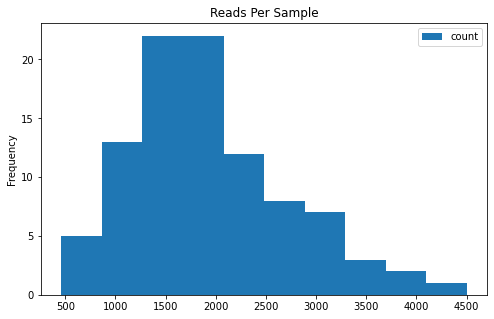

In [45]:
fig_counts_by_sample, axs_counts_by_sample = plt.subplots( figsize=(8,5) )
counts_by_sample.plot.hist(title='Reads Per Sample', ax=axs_counts_by_sample)

In [46]:
export_figure(fig_counts_by_sample, "counts_by_sample")

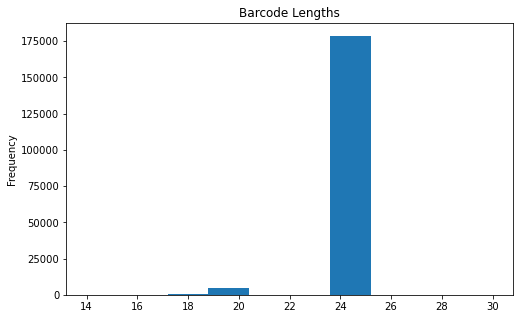

In [47]:
fig_barcode_lengths, axs_barcode_lengths = plt.subplots( figsize=(8,5) )
barcodes['barcode'].apply(len).plot.hist(title='Barcode Lengths', ax=axs_barcode_lengths)

In [48]:
export_figure(fig_barcode_lengths, "barcode_lengths")

In [49]:
counts_table = barcodes.groupby(by=["forward_primer","reverse_primer","sample","barcode"]).size().reset_index(name="count").sort_values(['forward_primer','reverse_primer','count'], ascending=[True,True,False])
counts_table.columns=["forward_primer","reverse_primer","sample","barcode","count"]
counts_table

,forward_primer,reverse_primer,sample,barcode,count
29,oVK025,oVK026,1514,GACTCACTCTCTGACAGAGACAGA,1298
72,oVK025,oVK026,1514,GTGTGTGAGTGACAGTGTGTCTGT,121
1,oVK025,oVK026,1514,CACAGTCACAGAGACTCTGACTCT,91
66,oVK025,oVK026,1514,GTGTCTCTGTCTCAGTGAGACACT,87
55,oVK025,oVK026,1514,GTCACTGTGTGTCTGACTCTGAGT,76
...,...,...,...,...,...
7230,oVK037,oVK048,,GAGTGTCACAGTGTGACTCACAGA,1
7237,oVK037,oVK048,,GTCACTGTCTCTGACAGA,1
7248,oVK037,oVK048,,GTCTGTGTGTGAGACT,1
7251,oVK037,oVK048,,GTGTCTGACTGTCACTGTGAGTCT,1


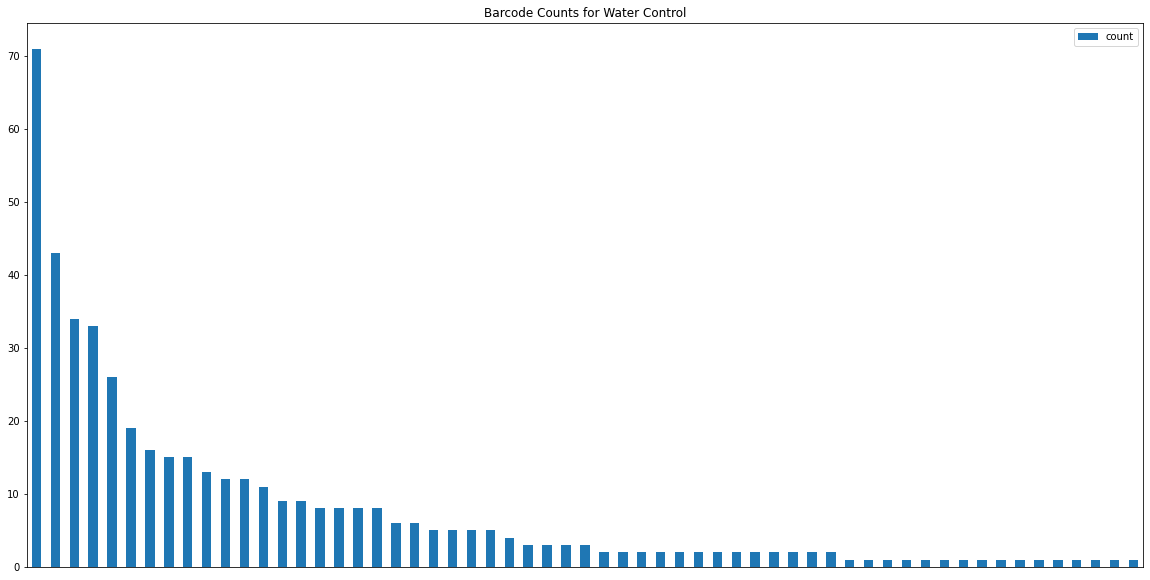

In [50]:
counts_table[counts_table['sample']=='water'].sort_values(
    "count", 
    ascending=False
).plot.bar(
    y="count", 
    xticks=[], 
    figsize=(20,10),
    title='Barcode Counts for Water Control'
)

In [51]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [52]:
samples_list = list( counts_table['sample'].unique() )

In [53]:
@interact
def counts_for_sample(sample=samples_list):
    return counts_table[ counts_table['sample'] == sample ] \
        .head(10) \
        .reset_index(drop=True) \
        .style.bar(subset=['count'],color='lightblue') \
        .hide_index() \
        .hide_columns(['sample','forward_primer','reverse_primer'])

interactive(children=(Dropdown(description='sample', options=('1514', '1515', '1516', '1517', '1518', '1519', …

In [54]:
water_count = max(counts_table[ counts_table['sample'] == 'water' ]['count'])
water_count

71

In [55]:
counts_table[ counts_table['count'] > water_count ]

,forward_primer,reverse_primer,sample,barcode,count
29,oVK025,oVK026,1514,GACTCACTCTCTGACAGAGACAGA,1298
72,oVK025,oVK026,1514,GTGTGTGAGTGACAGTGTGTCTGT,121
1,oVK025,oVK026,1514,CACAGTCACAGAGACTCTGACTCT,91
66,oVK025,oVK026,1514,GTGTCTCTGTCTCAGTGAGACACT,87
55,oVK025,oVK026,1514,GTCACTGTGTGTCTGACTCTGAGT,76
...,...,...,...,...,...
6957,oVK037,oVK044,289,GAGAGAGAGTGACAGTGACTCAGA,803
7016,oVK037,oVK045,431,CTGTGTGTGTCTGAGTCTGTGTGA,1313
7044,oVK037,oVK045,431,GTCACTGTGTGTCTGACTCTGAGT,100
7061,oVK037,oVK045,431,GTGTGTGAGTGACAGTGTGTCTGT,88


In [56]:
len( counts_table['barcode'].unique() )

521

In [57]:
top_10_counts_table = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(10))).reset_index()

In [58]:
top_10_counts_table

,forward_primer,reverse_primer,sample,barcode,count
0,oVK025,oVK026,1514,GACTCACTCTCTGACAGAGACAGA,1298
1,oVK025,oVK026,1514,GTGTGTGAGTGACAGTGTGTCTGT,121
2,oVK025,oVK026,1514,CACAGTCACAGAGACTCTGACTCT,91
3,oVK025,oVK026,1514,GTGTCTCTGTCTCAGTGAGACACT,87
4,oVK025,oVK026,1514,GTCACTGTGTGTCTGACTCTGAGT,76
...,...,...,...,...,...
955,oVK037,oVK048,,GTCACACTCACACTCACACACAGT,36
956,oVK037,oVK048,,GTGTCTGAGTGACTGAGAGT,35
957,oVK037,oVK048,,GAGAGAGAGTGAGAGTGACTCTGA,28
958,oVK037,oVK048,,CAGTGAGTGACTGAGACTGA,27


In [59]:
top_10_counts_table.to_excel(
    experiment + "_top_10_reads.xlsx",
    sheet_name = "Top 10 Reads"
)

In [60]:
counts_by_primers = barcodes.groupby(
    by=['forward_primer','reverse_primer','sample']) \
        .size() \
        .reset_index(name='count') \
        .sort_values(['count'], ascending=[False])
counts_by_primers

,forward_primer,reverse_primer,sample,count
61,oVK035,oVK038,1601,4505
62,oVK035,oVK039,1602,4085
68,oVK035,oVK045,1609,3846
71,oVK035,oVK048,1612,3638
60,oVK035,oVK026,1600,3588
...,...,...,...,...
30,oVK032,oVK043,1548,773
33,oVK032,oVK046,1617,642
46,oVK033,oVK047,1619,579
93,oVK037,oVK046,water,460


Text(0.5, 0.98, 'VK008')

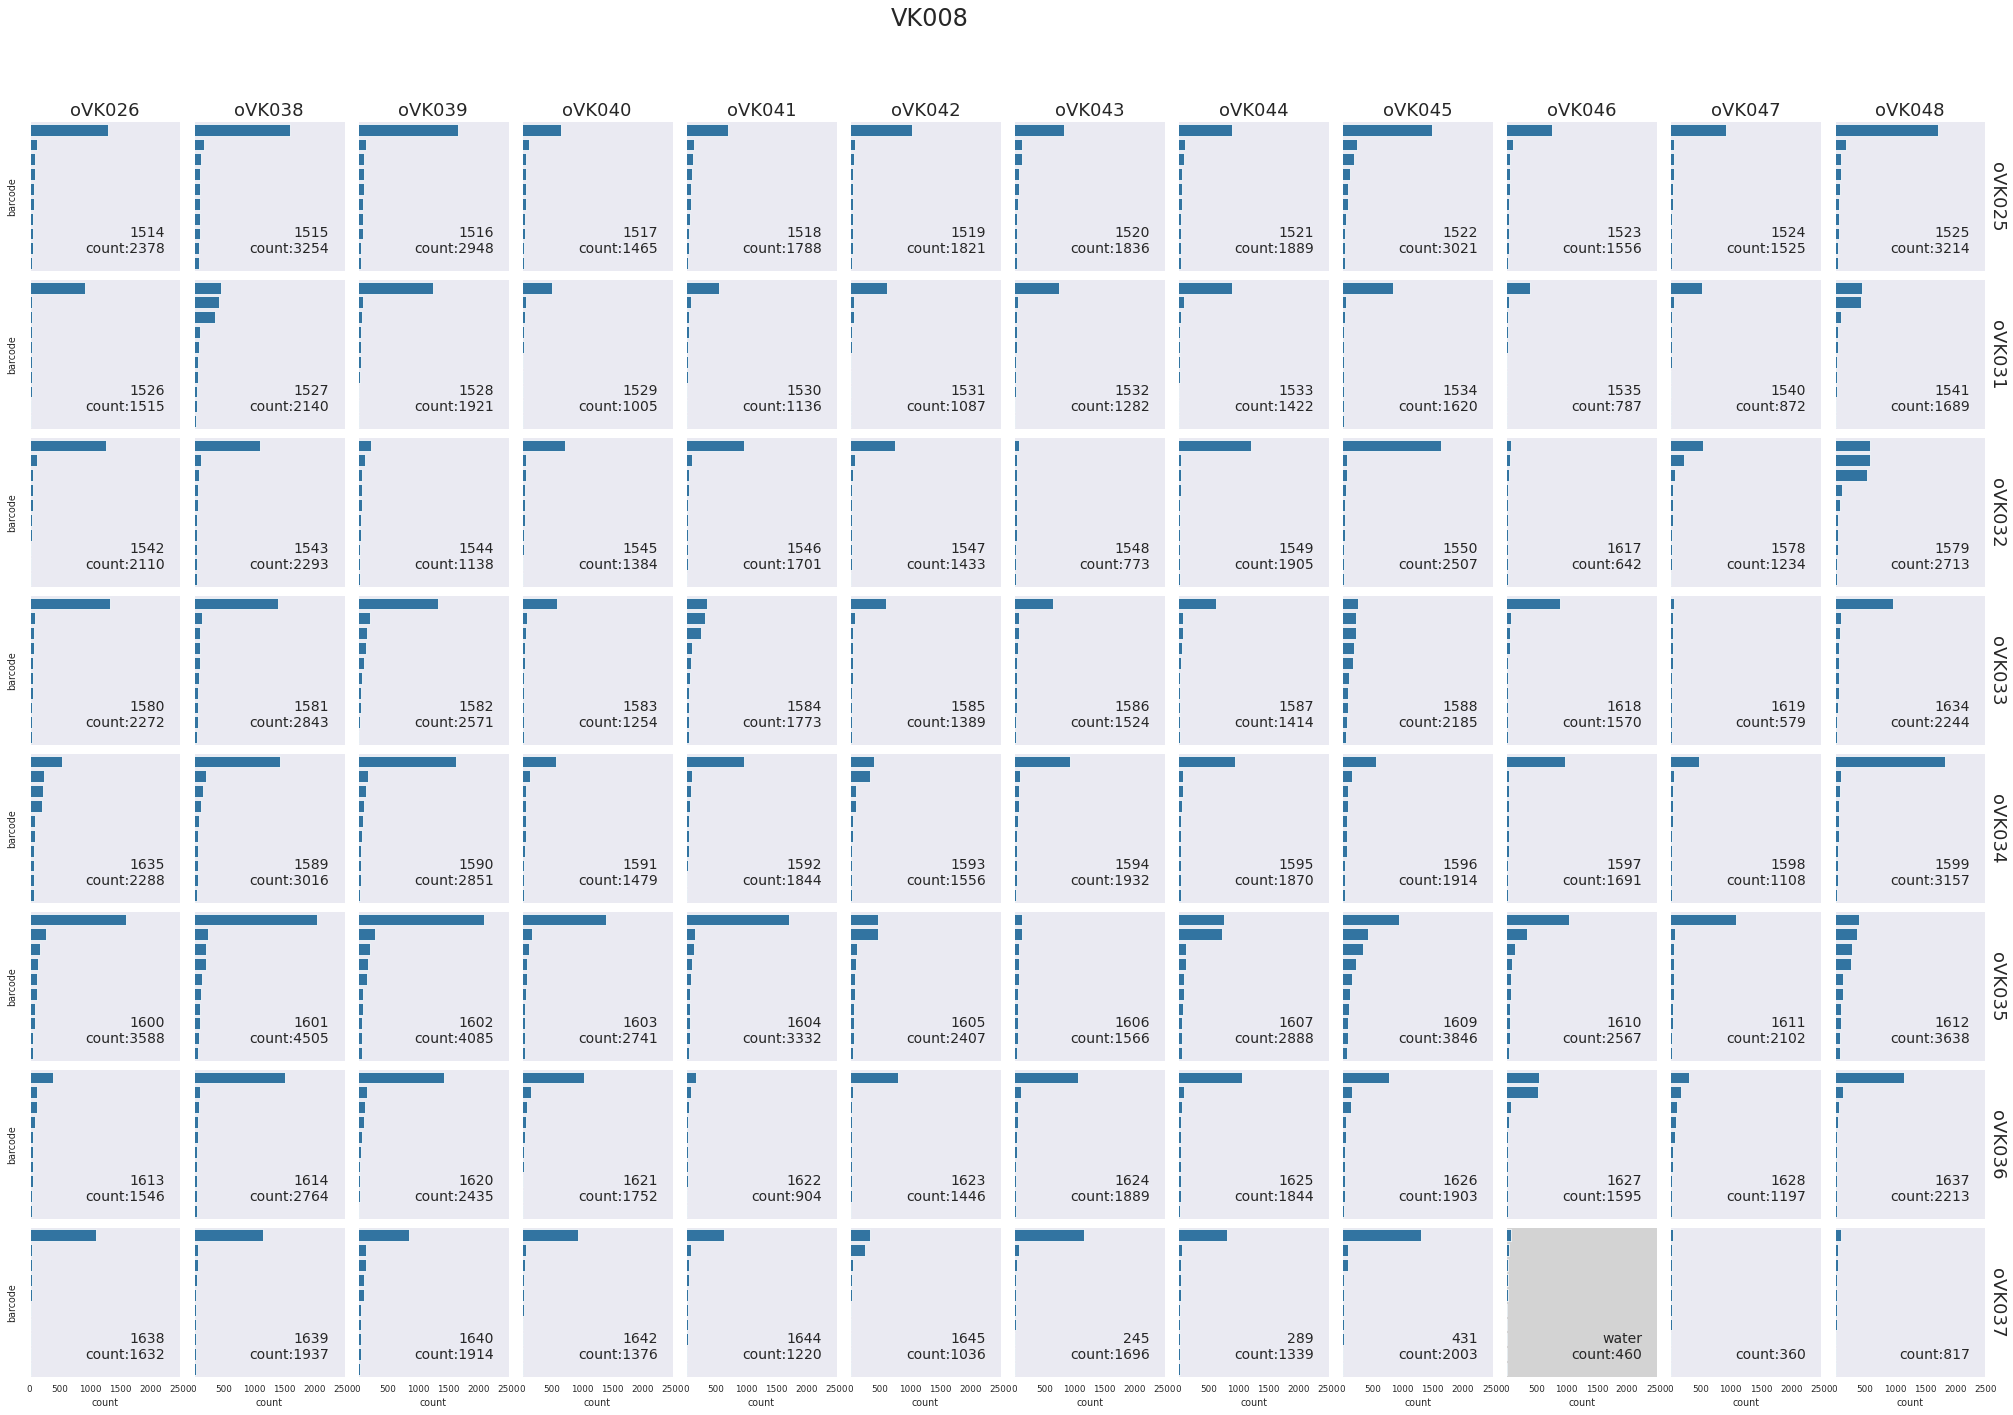

In [61]:
def annotate(data, **kws):
    f = data.iloc[0]['forward_primer']
    r = data.iloc[0]['reverse_primer']
    n = counts_by_primers[(counts_by_primers['forward_primer'] == f) & (counts_by_primers['reverse_primer'] == r)].iloc[0]['count']
    sample = sample_dict[f][r]
    ax = plt.gca()
    if sample == 'water':
        ax.set_facecolor('lightgrey')
        
    ax.text(.9, .1, f"{sample}\ncount:{n}", fontsize=14, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
hist_grid = sns.FacetGrid(top_10_counts_table, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
hist_grid.map_dataframe(
    sns.barplot, 
    x="count", 
    y="barcode",
    # order=counts_table['count'].value_counts().iloc[:5].index,
    orient='h')
hist_grid.map_dataframe(annotate)
hist_grid.set_yticklabels(None)
hist_grid.set_xticklabels(None)
hist_grid.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
plt.subplots_adjust(top=0.9)
hist_grid.fig.suptitle(experiment, fontsize=24)

In [62]:
export_figure(hist_grid, "histograms")

# Overlapping Barcodes

In [100]:
counts_table.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .count() \
    .sort_values(by=['count'], ascending=False)

,count
barcode,
GTCACTGTGTGTCTGACTCTGAGT,96
GTGTGTGAGTGACAGTGTGTCTGT,95
CTGTCAGAGAGAGAGTCACACACA,95
GACTCAGTGAGAGTGACTGTCTGA,94
CACAGTCACAGAGACTCTGACTCT,91
...,...
GAGACTCTCAGACTGTCTCA,1
GAGACTCTCAGACTGTCTGA,1
GAGAGAGAGTCAGACACACAGTCA,1


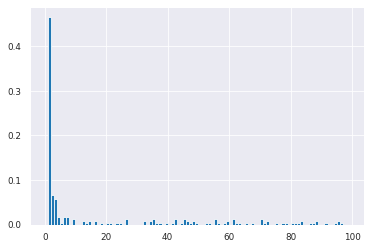

In [72]:
counts_table.groupby(by='barcode').size().hist(bins=range(0,100), density=True)

In [102]:
overlaps = counts_table.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .count() \
    .sort_values(by=['count'], ascending=False)
overlaps[(overlaps['count'] < 5) & (overlaps['count'] > 1)]

,count
barcode,
CACACAGAGAGACTGACAGAGTCA,4
CTCTCTGTGTGTCTGAGTCACTCT,4
GTGTCTGTGACAGAGTGACTGTCT,4
GTGACTGTGAGTCTCAGTGACAGT,4
GAGTGTCTGTGTGACTGTGACACT,3
CTCTGTGTCACTGAGTGAGTCACA,3
CTGACAGTCTGAGAGTCACTCTCA,3
CTGAGTCTCACAGAGAGTGACACT,3
CTGTCTCTGTCTGTGACAGAGTGT,3


In [104]:
counts_and_overlaps = counts_table.set_index('barcode').join(overlaps, how='inner', lsuffix='_reads', rsuffix='_overlaps')
counts_and_overlaps

,forward_primer,reverse_primer,sample,count_reads,count_overlaps
barcode,,,,,
CACACAGAGAGACTGACAGAGTCA,oVK025,oVK026,1514,1,4
CACACAGAGAGACTGACAGAGTCA,oVK034,oVK045,1596,1,4
CACACAGAGAGACTGACAGAGTCA,oVK035,oVK043,1606,1,4
CACACAGAGAGACTGACAGAGTCA,oVK035,oVK045,1609,1,4
CACAGAGAGACACTGTCAGTCTCT,oVK035,oVK047,1611,1,1
...,...,...,...,...,...
GTGTGTGTCTGAGAGACAGTGAGA,oVK037,oVK047,,1,86
GTGTGTGTCTGAGAGACAGTGAGA,oVK037,oVK048,,1,86
GTGTGTGTGACAGTGACTCAGAGT,oVK025,oVK041,1518,2,2


In [118]:
bc1 = counts_table['barcode'].iloc[0]
bc1

'GACTCACTCTCTGACAGAGACAGA'

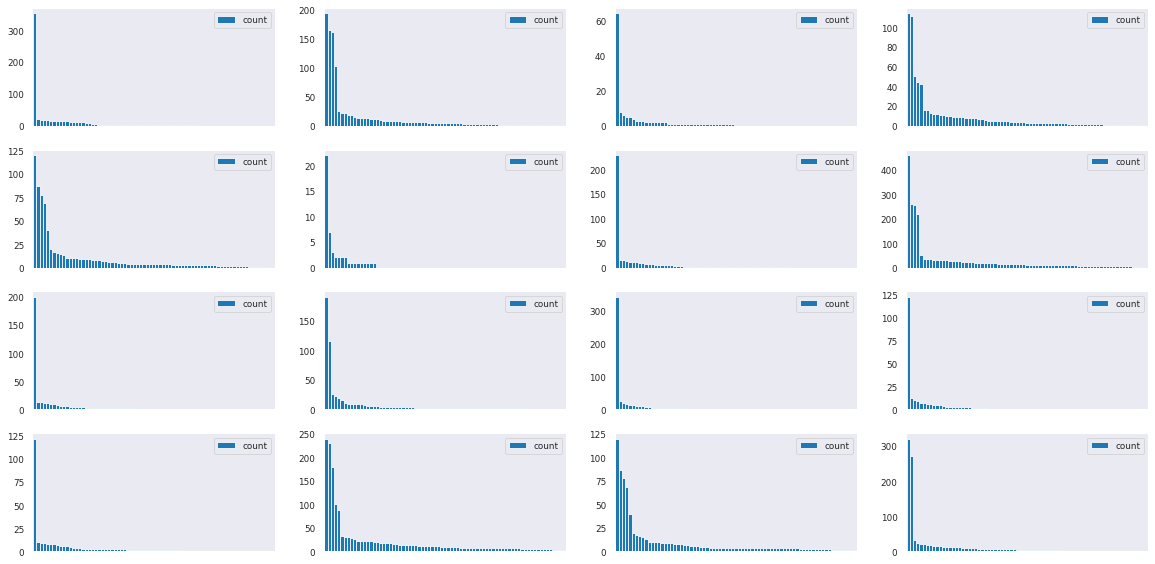

In [167]:
h, w = (4,4)
barcode_list = list( counts_table['barcode'].sample(n=h*w) )
# print(barcode_list)
fig, axs = plt.subplots(h, w, figsize=(20,10), sharex=True)

for ax, bc in zip([ax for subaxs in axs for ax in subaxs], barcode_list):
    counts_table[counts_table['barcode'] == bc] \
        .sort_values(by='count', ascending=False) \
        .plot \
        .bar(
            ax=ax,
            xticks=[], 
            width=1
        )
plt.show()

In [145]:
counts_table.groupby('barcode').head()

,forward_primer,reverse_primer,sample,barcode,count
17,oVK025,oVK026,1514,GACTCACTCTCTGACAGAGACAGA,256
42,oVK025,oVK026,1514,GTGTGTGAGTGACAGTGTGTCTGT,31
1,oVK025,oVK026,1514,CACAGTCACAGAGACTCTGACTCT,23
39,oVK025,oVK026,1514,GTGTCTCTGTCTCAGTGAGACACT,21
31,oVK025,oVK026,1514,GAGTGTGAGAGACAGTGTGACTGT,15
...,...,...,...,...,...
4195,oVK037,oVK044,289,GTCTGTCTCACAGACTCTCTCACA,1
4235,oVK037,oVK045,431,GTCTGAGACTGAGTGA,2
4204,oVK037,oVK045,431,CTCAGACTGAGACACTCACACTCA,1
4214,oVK037,oVK045,431,GACAGTGACTGTGAGAGAGTCTCA,1


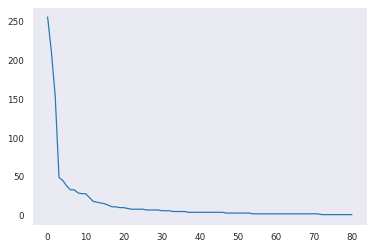

In [166]:
counts_table[ counts_table['barcode'] == bc1 ]['count'] \
    .sort_values(ascending=False) \
    .reset_index() \
    .plot \
    .line(
        y='count',
        legend=False)

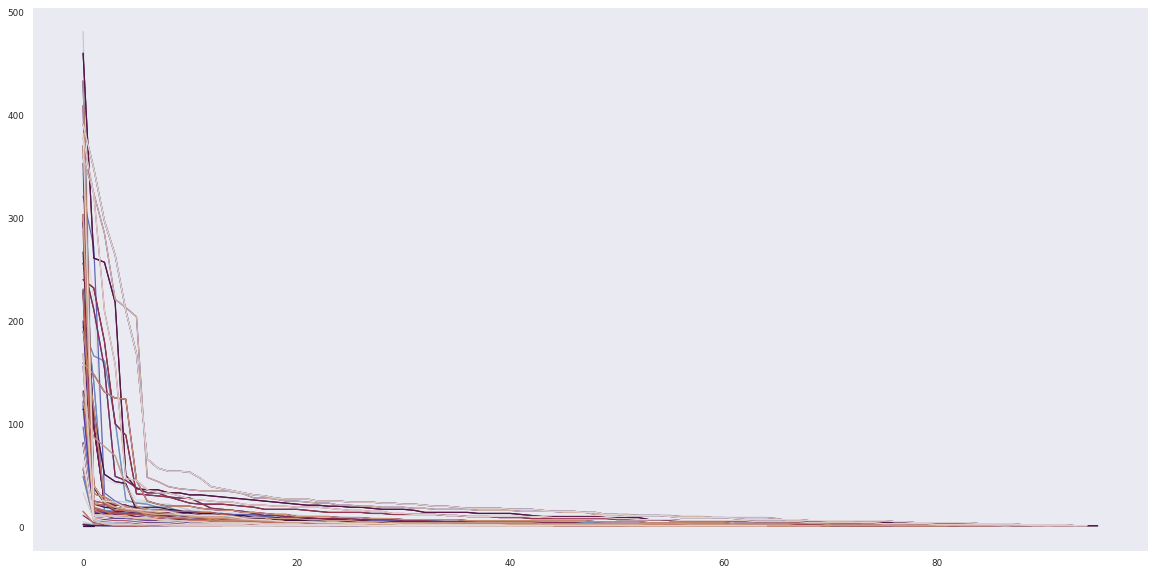

In [187]:
N = 100

barcode_list = list( counts_table['barcode'].sample(n=N) )
fig, ax = plt.subplots(figsize=(20,10), sharex=True)

colors = plt.cm.twilight(np.linspace(0,1,N))
for bc, c in zip(barcode_list, colors):
    # print(f'barcode: {bc}\tcolor: {c}')
    counts_table[ counts_table['barcode'] == bc ]['count'] \
        .sort_values(ascending=False) \
        .reset_index() \
        .plot \
        .line(
            ax=ax,
            y='count',
            color=tuple(c),
            legend=False)

ValueError: too many values to unpack (expected 2)

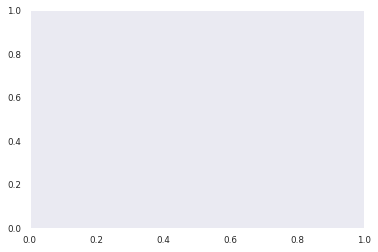

In [144]:
# barcode_list = list( counts_table['barcode'].sample(n=10) )

fig, ax = plt.subplots()
for label, grp in counts_table.groupby('barcode').head():
    # print(grp)
    grp.sort_values(by='count', ascending=False).plot(ax=ax)
    # grp.plot(x = grp.index, y = 'count', ax = ax, label = label)

### Examine the data, starting with the first few reads

In [90]:
counts_and_overlaps[counts_and_overlaps['count_overlap'] == 2]

,forward_primer,reverse_primer,sample,count_reads,count_overlap
barcode,,,,,
CAGTCAGTGACTGACAGAGTCACA,oVK031,oVK038,1527,1,2
CAGTCAGTGACTGACAGAGTCACA,oVK032,oVK045,1550,1,2
CTCTCACTCAGAGTCTCTCTGTCT,oVK032,oVK039,1544,1,2
CTCTCACTCAGAGTCTCTCTGTCT,oVK034,oVK048,1599,1,2
CTGACAGACACACTCACACACTGT,oVK031,oVK046,1535,1,2
CTGACAGACACACTCACACACTGT,oVK032,oVK039,1544,2,2
CTGACTGTCTCTCAGAGACTCAGA,oVK031,oVK045,1534,3,2
CTGACTGTCTCTCAGAGACTCAGA,oVK037,oVK038,1639,1,2
GACAGACTGACTGTGTGTCTGTCTCACA,oVK025,oVK040,1517,2,2


In [108]:
counts_and_overlaps[counts_and_overlaps['sample'] == 'water'].sort_values(by='count_overlaps', ascending=False)

,forward_primer,reverse_primer,sample,count_reads,count_overlaps
barcode,,,,,
GTCACTGTGTGTCTGACTCTGAGT,oVK037,oVK046,water,14,96
GTGTGTGAGTGACAGTGTGTCTGT,oVK037,oVK046,water,2,95
CTGTCAGAGAGAGAGTCACACACA,oVK037,oVK046,water,1,95
GACTCAGTGAGAGTGACTGTCTGA,oVK037,oVK046,water,6,94
CACAGTCACAGAGACTCTGACTCT,oVK037,oVK046,water,7,91
CTGTCTGAGAGACAGACTGTCTGA,oVK037,oVK046,water,1,88
CAGTGTGTCACTCACTCTGTCTCA,oVK037,oVK046,water,1,88
GTCAGTGAGACTCTCTCAGAGTGT,oVK037,oVK046,water,1,83
GTGTCTCTGTCTCAGTGAGACACT,oVK037,oVK046,water,2,83


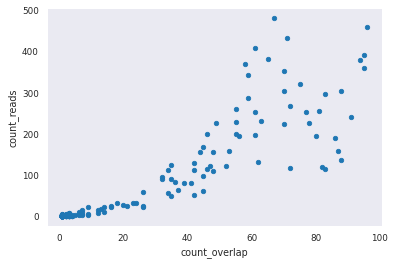

In [99]:
counts_and_overlaps.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .max() \
    .plot(x='count_overlap', y='count_reads', kind='scatter')

In [109]:
# https://matplotlib.org/stable/gallery/specialty_plots/hinton_demo.html

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

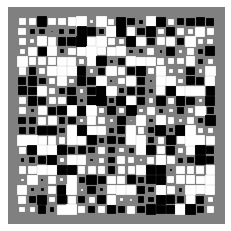

In [110]:
np.random.seed(19680801)
hinton(np.random.rand(20, 20) - 0.5)
plt.show()

# Other Stuff

In [25]:
def invertLocation(loc, seqLen):
    return seqLen - 1 - loc

def printSeqOriented(n, table):
    read = table.iloc[n]
    sequence = read['sequence']
    if read['R1_fwd_direction'] == 'F':
        intervals = [
                [read['R1_fwd_primer_loc'], read['R1_fwd_primer_loc'] + primer_lookup[read['R1_fwd_primer']]['len'] ],
                [read['R1_rc_primer_loc'], read['R1_rc_primer_loc'] + primer_lookup[read['R1_rc_primer']]['len']],
                read['R1_barcode_loc']
            ]
    else:
        l = len(sequence)
        intervals = [
                [read['R2_fwd_primer_loc'], read['R2_fwd_primer_loc'] + primer_lookup[read['R2_fwd_primer']]['len'] ],
                [read['R2_rc_primer_loc'], read['R2_rc_primer_loc'] + primer_lookup[read['R2_rc_primer']]['len']],
                read['R1_barcode_loc']
            ]
        intervals = [[l-b,l-a] for [a, b] in intervals]
    # print(intervals)
    highlights = colorIntervals(sequence, intervals)
    return highlights

In [26]:
for i in range(25):
    print( "{0:4d} {1}".format(i, reads_table.iloc[i]['R1_fwd_direction']), printSeqOriented(i, reads_table) )


   0 R GCTACCGAGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTGTGTGTCACTGTCTCTGACAGAACGCGTCTGGAACAATCAACCTCTGGATCGTAAAA
   1 R GCTACCTTGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTGTCTCTGTCTCAGTGAGACACTACGCGTCTGGAACAATCAACCTCTGGGTGACAAAA
   2 R GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGACTGTGTCAGTGAGAGTGACTCTACGCGTCTGGAACAATCAACCTCTGGAATGGAAAA
   3 R GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTCAGTGAGACTCTCTCAGAGTGTACGCGTCTGGAACAATCAACCTCTGGATCGTAAAA
   4 F GCTGCCGAAGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTCACTGTGTGTCTGACTCTGAGTACGCGTCTGGAACAATCAACCTCTGTATCTCAAAA
   5 R GCTACCACCGATATTGCTGAAGAGCTTG

In [36]:
top_5_reads = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(5))).reset_index()
top_5_reads["rank"] = top_5_reads.groupby(by=["forward_primer","reverse_primer"]).rank(method="first", ascending=False).astype(int)
top_5_reads

,forward_primer,reverse_primer,barcode,count,rank
0,oVK025,oVK026,GACTCACTCTCTGACAGAGACAGA,1456,1
1,oVK025,oVK026,GTGTGTGAGTGACAGTGTGTCTGT,141,2
2,oVK025,oVK026,CACAGTCACAGAGACTCTGACTCT,106,3
3,oVK025,oVK026,GTGTCTCTGTCTCAGTGAGACACT,99,4
4,oVK025,oVK026,GAGTGTGAGAGACAGTGTGACTGT,82,5
...,...,...,...,...,...
475,oVK037,oVK048,GTCACTGTGTGTCTGACTCTGAGT,119,1
476,oVK037,oVK048,GTGTGTGTCACTGTCTCTGACAGA,59,2
477,oVK037,oVK048,CTGTGTGTGTCTGAGTCTGTGTGA,56,3
478,oVK037,oVK048,GAGAGTCAGAGTCTGACTGACTGA,55,4


In [39]:
top_5_reads.to_excel('top_5_barcodes.xlsx')

#### Compute the total number of reads, and annotate the plots.

In [43]:
g2.savefig("histograms.png")

## Filter for Clones with 1 or 2 Dominant Barcodes

In [42]:
# sample_dict = {row_headers[r]:{col_headers[c]:data[r][c] for c in range(len(col_headers))} for r in range(0, len(row_headers))}

In [43]:
top_5_reads['sample']=top_5_reads.apply(
    lambda row: sample_dict[ row['forward_primer'] ][ row['reverse_primer'] ],
    axis=1
)

In [44]:
top_5_reads

,forward_primer,reverse_primer,barcode,count,rank,sample
0,oVK025,oVK026,GACTCACTCTCTGACAGAGACAGA,1456,1,1514
1,oVK025,oVK026,GTGTGTGAGTGACAGTGTGTCTGT,141,2,1514
2,oVK025,oVK026,CACAGTCACAGAGACTCTGACTCT,106,3,1514
3,oVK025,oVK026,GTGTCTCTGTCTCAGTGAGACACT,99,4,1514
4,oVK025,oVK026,GAGTGTGAGAGACAGTGTGACTGT,82,5,1514
...,...,...,...,...,...,...
475,oVK037,oVK048,GTCACTGTGTGTCTGACTCTGAGT,119,1,
476,oVK037,oVK048,GTGTGTGTCACTGTCTCTGACAGA,59,2,
477,oVK037,oVK048,CTGTGTGTGTCTGAGTCTGTGTGA,56,3,
478,oVK037,oVK048,GAGAGTCAGAGTCTGACTGACTGA,55,4,


In [45]:
top_5_reads[top_5_reads['sample'] == 'water']

,forward_primer,reverse_primer,barcode,count,rank,sample
465,oVK037,oVK046,GTCACTGTGTGTCTGACTCTGAGT,78,1,water
466,oVK037,oVK046,GTCAGACTCTGACACTGAGACACA,48,2,water
467,oVK037,oVK046,GAGTGTCAGTCTGTGAGTGAGACT,39,3,water
468,oVK037,oVK046,GACTCAGTGAGAGTGACTGTCTGA,38,4,water
469,oVK037,oVK046,CTGTGTGTGTCTGAGTCTGTGTGA,31,5,water


In [46]:
water_count = top_5_reads[top_5_reads['sample'] == 'water']['count'].max()
water_count

78

In [47]:
top_5_reads[top_5_reads['count'] > water_count]

,forward_primer,reverse_primer,barcode,count,rank,sample
0,oVK025,oVK026,GACTCACTCTCTGACAGAGACAGA,1456,1,1514
1,oVK025,oVK026,GTGTGTGAGTGACAGTGTGTCTGT,141,2,1514
2,oVK025,oVK026,CACAGTCACAGAGACTCTGACTCT,106,3,1514
3,oVK025,oVK026,GTGTCTCTGTCTCAGTGAGACACT,99,4,1514
4,oVK025,oVK026,GAGTGTGAGAGACAGTGTGACTGT,82,5,1514
...,...,...,...,...,...,...
455,oVK037,oVK044,GAGAGAGAGTGACAGTGACTCAGA,920,1,289
460,oVK037,oVK045,CTGTGTGTGTCTGAGTCTGTGTGA,1659,1,431
461,oVK037,oVK045,GTCACTGTGTGTCTGACTCTGAGT,111,2,431
462,oVK037,oVK045,GTGTGTGAGTGACAGTGTGTCTGT,101,3,431


In [48]:
counts_table['sample'] = counts_table.apply(
    lambda row: sample_dict[ row['forward_primer'] ][ row['reverse_primer'] ],
    axis=1
)

In [50]:
top_5_reads.groupby(['forward_primer','reverse_primer'])['count'].sum()

forward_primer  reverse_primer
oVK025          oVK026            1884
                oVK038            2436
                oVK039            2384
                oVK040            1852
                oVK041            1939
                                  ... 
oVK037          oVK044            1152
                oVK045            1952
                oVK046             234
                oVK047             173
                oVK048             343
Name: count, Length: 96, dtype: int64

In [51]:
y = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(10)))
y['cumsum'] = y.groupby(level=[0,1])['count'].transform('cumsum')
y['running_percent'] = y['cumsum'] / y.groupby(level=[0,1])['count'].transform('sum')
y

barcode  count sample  cumsum  \
forward_primer reverse_primer                                                   
oVK025         oVK026          GACTCACTCTCTGACAGAGACAGA   1456   1514    1456   
               oVK026          GTGTGTGAGTGACAGTGTGTCTGT    141   1514    1597   
               oVK026          CACAGTCACAGAGACTCTGACTCT    106   1514    1703   
               oVK026          GTGTCTCTGTCTCAGTGAGACACT     99   1514    1802   
               oVK026          GAGTGTGAGAGACAGTGTGACTGT     82   1514    1884   
...                                                 ...    ...    ...     ...   
oVK037         oVK048          CTGAGACTGACACTGACACAGAGT     48            391   
               oVK048          GTCACACTCACACTCACACACAGT     41            432   
               oVK048              GTGTCTGAGTGACTGAGAGT     38            470   
               oVK048          CAGTGTGTCACTCACTCTGTCTCA     30            500   
               oVK048              CAGTGAGTGACTGAGACTGA     28            528   

                               running_percent  
forward_primer reverse_primer                   
oVK025         oVK026                 0.649710  
               oVK026                 0.712628  
               oVK026                 0.759929  
               oVK026                 0.804105  
               oVK026                 0.840696  
...                                        ...  
oVK037         oVK048                 0.740530  
               oVK048                 0.818182  
               oVK048                 0.890152  
               oVK048                 0.946970  
               oVK048                 1.000000  

[960 rows x 5 columns]

Text(0.5, 0.98, 'VK008')

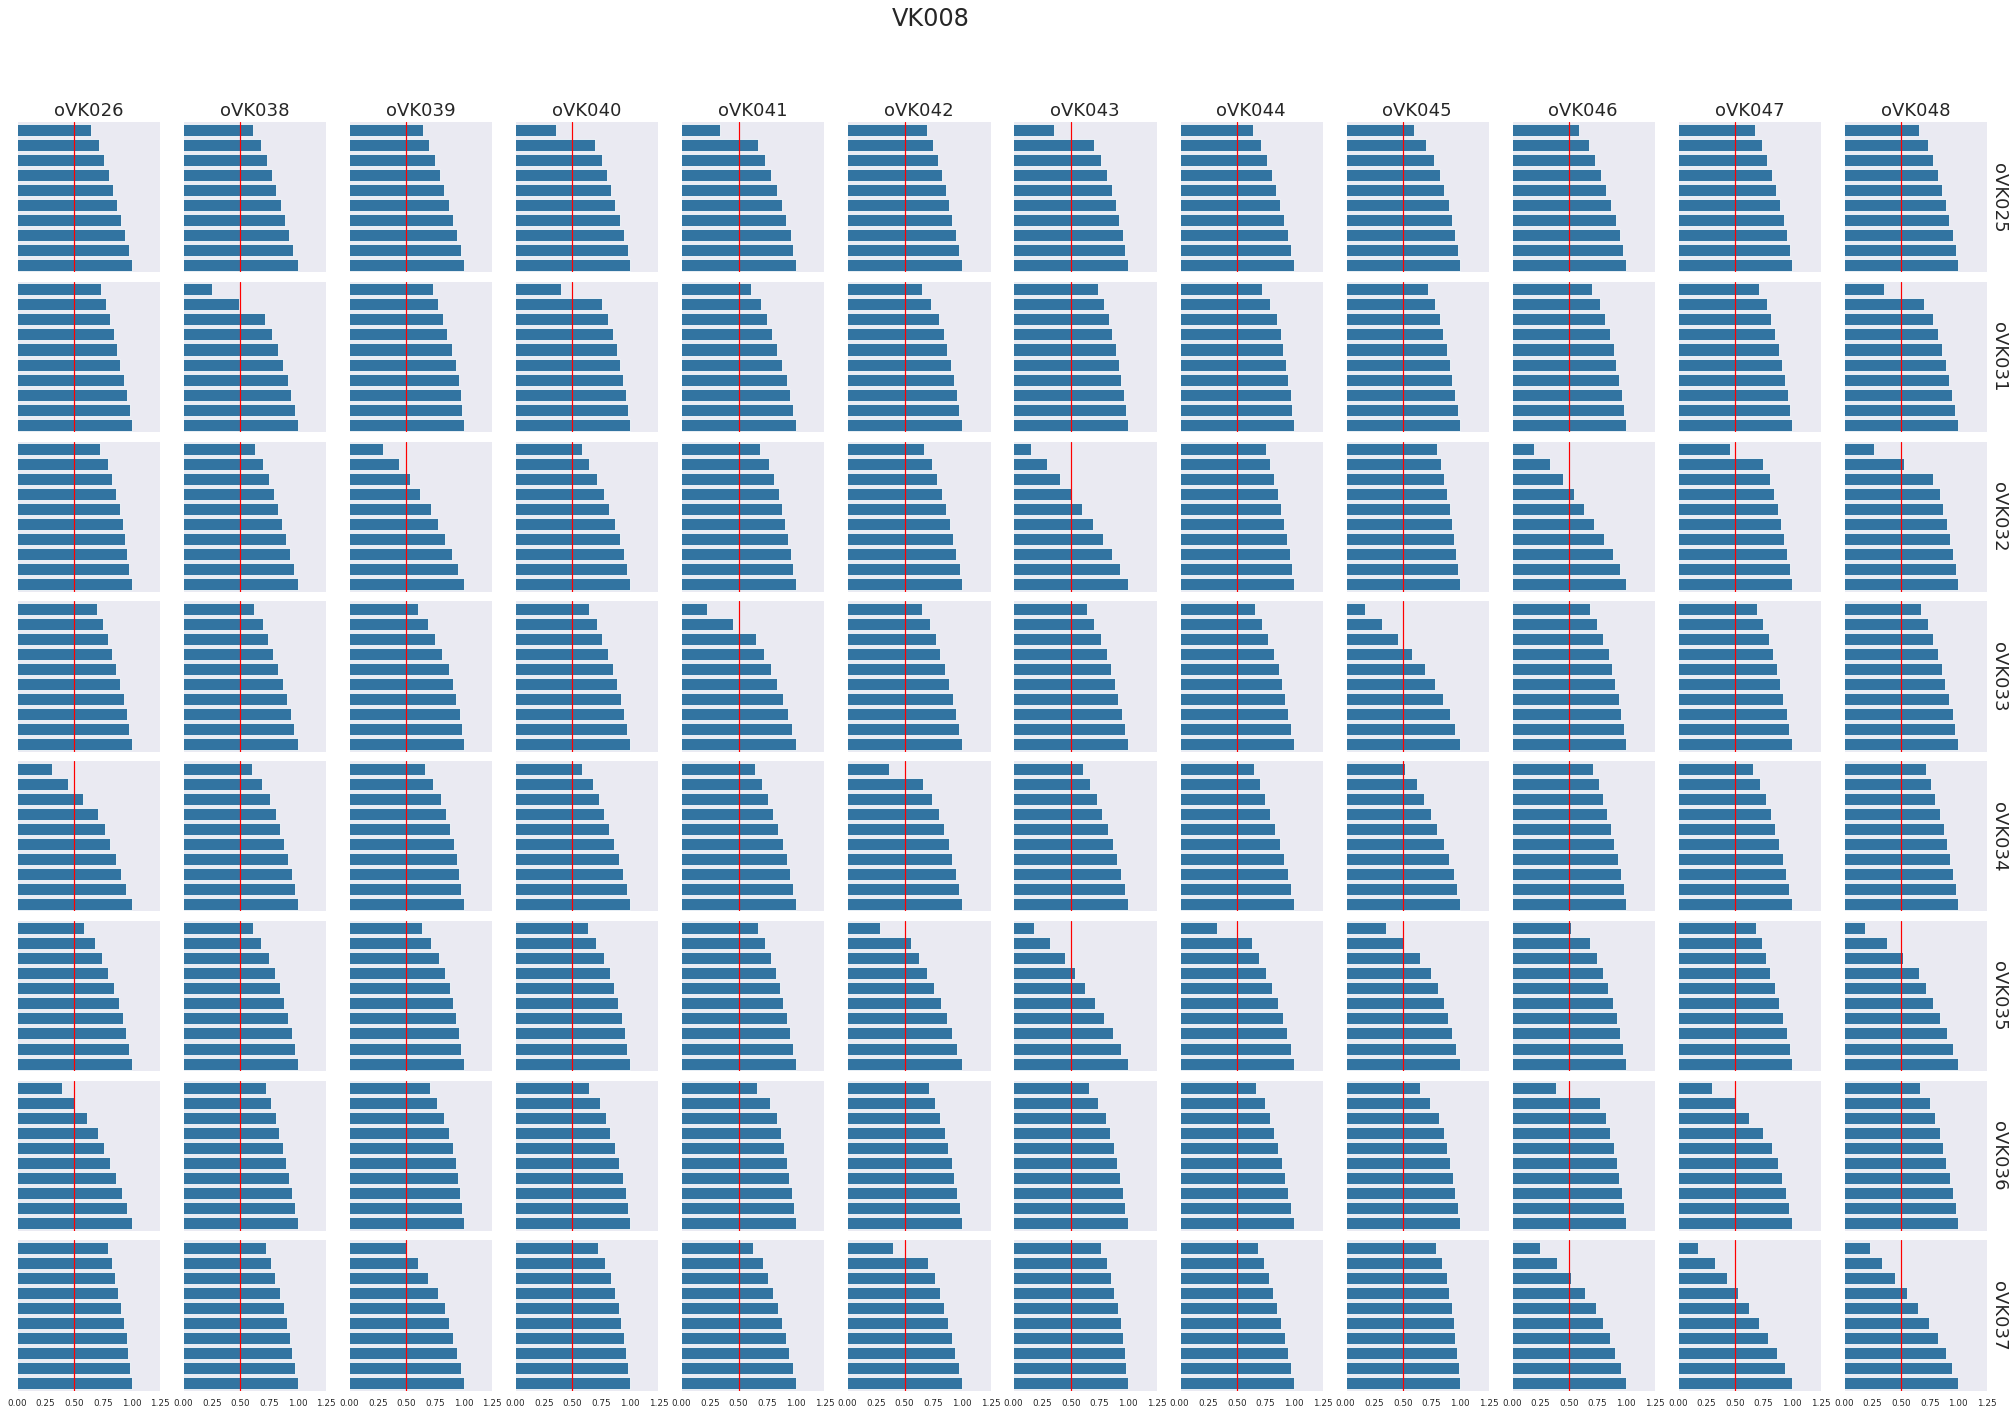

In [52]:
z = y.reset_index()
sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(z, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="running_percent",y="barcode", orient='h')
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)

for ax in g2.axes.flat:
    ax.axvline(x=0.5, color='r', linestyle='-')

plt.subplots_adjust(top=0.9)
g2.fig.suptitle(experiment, fontsize=24)

In [53]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [59]:
samples_list = [s for sublist in data for s in sublist if s != '']
samples_list

['1514',
 '1515',
 '1516',
 '1517',
 '1518',
 '1519',
 '1520',
 '1521',
 '1522',
 '1523',
 '1524',
 '1525',
 '1526',
 '1527',
 '1528',
 '1529',
 '1530',
 '1531',
 '1532',
 '1533',
 '1534',
 '1535',
 '1540',
 '1541',
 '1542',
 '1543',
 '1544',
 '1545',
 '1546',
 '1547',
 '1548',
 '1549',
 '1550',
 '1617',
 '1578',
 '1579',
 '1580',
 '1581',
 '1582',
 '1583',
 '1584',
 '1585',
 '1586',
 '1587',
 '1588',
 '1618',
 '1619',
 '1634',
 '1635',
 '1589',
 '1590',
 '1591',
 '1592',
 '1593',
 '1594',
 '1595',
 '1596',
 '1597',
 '1598',
 '1599',
 '1600',
 '1601',
 '1602',
 '1603',
 '1604',
 '1605',
 '1606',
 '1607',
 '1609',
 '1610',
 '1611',
 '1612',
 '1613',
 '1614',
 '1620',
 '1621',
 '1622',
 '1623',
 '1624',
 '1625',
 '1626',
 '1627',
 '1628',
 '1637',
 '1638',
 '1639',
 '1640',
 '1642',
 '1644',
 '1645',
 '245',
 '289',
 '431',
 'water']

In [86]:
sample_N_table = {}

@interact
def pick_N_for_sample(sample=samples_list, barcode_count=[1,2,3,4,'many']):
    sample_N_table[sample] = barcode_count
    return counts_table[counts_table['sample']==sample].sort_values("count", ascending=False).head(25).plot.bar(
        y="count", 
        xticks=[], 
        figsize=(10,5), 
        linewidth=1,
        width=1)

interactive(children=(Dropdown(description='sample', options=('1514', '1515', '1516', '1517', '1518', '1519', …

In [91]:
sample_N_table

{'1514': 1,
 '1515': 1,
 '1516': 1,
 '1517': 2,
 '1518': 2,
 '1519': 1,
 '1520': 2,
 '1521': 1,
 '1522': 1,
 '1523': 1,
 '1524': 1,
 '1525': 1,
 '1526': 1,
 '1527': 3,
 '1528': 1,
 '1529': 2,
 '1530': 1,
 '1531': 1,
 '1532': 1,
 '1533': 1,
 '1534': 1,
 '1535': 1,
 '1540': 1,
 '1541': 2,
 '1542': 1,
 '1543': 1,
 '1544': 'many',
 '1545': 1,
 '1546': 1,
 '1547': 1,
 '1548': 'many',
 '1549': 1,
 '1550': 1,
 '1617': 'many',
 '1578': 'many',
 '1579': 3,
 '1580': 1,
 '1581': 1,
 '1582': 1,
 '1583': 1,
 '1584': 3,
 '1585': 1,
 '1586': 1,
 '1587': 1,
 '1588': 'many',
 '1618': 1,
 '1619': 1,
 '1634': 1,
 '1635': 'many',
 '1589': 1,
 '1590': 1,
 '1591': 1,
 '1592': 1,
 '1593': 2,
 '1594': 1,
 '1595': 1,
 '1596': 1,
 '1597': 1,
 '1598': 1,
 '1599': 1,
 '1600': 1,
 '1601': 1,
 '1602': 1,
 '1603': 1,
 '1604': 1,
 '1605': 2,
 '1606': 'many',
 '1607': 2,
 '1609': 'many',
 '1610': 'many',
 '1611': 1,
 '1612': 'many',
 '1613': 'many',
 '1614': 1,
 '1620': 1,
 '1621': 1,
 '1622': 1,
 '1623': 1,
 '1624': 

In [92]:
with open('sample_N_table.csv', 'w') as sample_N:
    print(sample_N_table, file=sample_N)

### Find overlapping barcodes

In [45]:
fwd = "oVK025"
rev = "oVK038"
bc = counts_table[(counts_table['forward_primer']==fwd) & (counts_table['reverse_primer']==rev)].nlargest(1,"count")["barcode"].iloc[0]
bc

'CTAAGTGAGTGACAGAGTGTCTCA'

In [46]:
counts_table[counts_table['barcode'] == bc]

,forward_primer,reverse_primer,barcode,count
8,oVK025,oVK026,CTAAGTGAGTGACAGAGTGTCTCA,4
102,oVK025,oVK038,CTAAGTGAGTGACAGAGTGTCTCA,243
185,oVK025,oVK039,CTAAGTGAGTGACAGAGTGTCTCA,8
286,oVK025,oVK040,CTAAGTGAGTGACAGAGTGTCTCA,1
340,oVK025,oVK041,CTAAGTGAGTGACAGAGTGTCTCA,4
397,oVK025,oVK042,CTAAGTGAGTGACAGAGTGTCTCA,1
443,oVK025,oVK043,CTAAGTGAGTGACAGAGTGTCTCA,2
494,oVK025,oVK044,CTAAGTGAGTGACAGAGTGTCTCA,4
559,oVK025,oVK045,CTAAGTGAGTGACAGAGTGTCTCA,2
629,oVK025,oVK046,CTAAGTGAGTGACAGAGTGTCTCA,9
